## Contaminante en un flujo de agua subterráneas.

**Objetivo.**
Resolver numéricamente el transporte de un contaminante en un acuífero.

 <p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/intro_MeIA_2023">MACTI NOTES</a> by <span property="cc:attributionName">Luis Miguel de la Cruz Salas</span> is licensed under <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">CC BY-NC-SA 4.0<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p> 

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101922**

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import macti.visual as mvis

from macti.evaluation import *


print('Python', sys.version)
print(np.__name__, np.__version__)
print(plt.matplotlib.__name__, plt.matplotlib.__version__)

Python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
numpy 1.26.2
matplotlib 3.8.1


In [13]:
quizz = Quizz('1', 'notebooks', 'local')

<a name='1'></a>
## Modelo conceptual.

Consideremos un acuífero de $Lx = 804.7$ [m] y $Ly = 804.7$ [m] y una fuenta de contaminante localizada en la pared izquierda y acotado por un río en la pared derecha, véase figura. Se considera que el contaminante que se modela es conservativo, es decir, que su concentración no varía al interactuar con el medio y que, por tanto, al atravesar el acuífero mantiene sus propiedades durante todo su recorrido. Se cuenta con un modelo de flujo y transporte de una sola capa, en dos dimensiones. El flujo del
agua en el acuífero está en estado de equilibrio. Las condiciones de frontera son las que se muestran en la figura, para la carga hidraúlica $h$ y para la concentración $c$.

<img src="./gr2.jpg" width="500px" align="center">

El valor de la carga hidráulica en la pared izquierda es de $h = 50$ [m] y en la pared derecha es de $h=0$ [m], en las otras paredes se considera no flujo.
La fuente de contaminante que está activa durante el periodo de simulación tiene un valor constante de $c = 50$ ppm. En los otros lugares de la frontera se considera no flujo del contaminante.
Inicialmente $h = 25$ [m] y $c = 0$ ppm en el interior del dominio.

La porosidad tiene un valor de $\phi = 0.25$, la dispersividad en dirección $x$ tiene un valor de $Dx = 33$ [m] y en dirección $y$ tiene el valor de $Dy = 3.3$ [m]. $K = 21.22$ [m/s] y $S_s = 1.0$


**Fuente**:
Leyva-Suárez, Esther, Herrera, Graciela S., & de la Cruz, Luis M.. (2015). A parallel computing strategy for Monte Carlo simulation using groundwater models. Geofísica internacional, 54(3), 245-254. https://doi.org/10.1016/j.gi.2015.04.020

In [5]:
# Parámetros físicos
K = 1.0 # 21.22  # Conductividad
Dx = 1.0 # 33.0
Dy = 1.0 # 3.3
𝜙 = 1.0 # 0.25
Lx = 1.0 # 804.7  # Longitud del dominio en dirección x
Ly = 1.0 # 804.7  # Longitud del dominio en dirección y

print('Parámetros físicos' + '\n' + 40*'-')
print('Conductividad K = {}'.format(K))
print('Conductividad (Dx, Dy) = ({}, {})'.format(Dx, Dy))
print('Porosidad 𝜙 = {}'.format(𝜙))
print('Longitud en x = {} | Longitud en y = {}'.format(Lx,Ly))

Parámetros físicos
----------------------------------------
Conductividad K = 1.0
Conductividad (Dx, Dy) = (1.0, 1.0)
Porosidad 𝜙 = 1.0
Longitud en x = 1.0 | Longitud en y = 1.0


<a name='2'></a>
## Modelo matemático.
Para este modelo usaremos las ecuaciones de flujo y transporte acopladas por la ley de Darcy para describir la evolución de la pluma del contaminante. Estas ecuaciones se van a resolver para las cargas hidráulicas y las concentraciones del contaminante y se escriben como sigue:

$$
\begin{eqnarray}
S_s\dfrac{\partial h}{ \partial t} & = & K \left(\dfrac{\partial^2 h}{ \partial x^2} + \dfrac{\partial^2 h}{ \partial y^2}\right) \tag{1} \\
V & = & -K \nabla h \tag{2} \\
\phi \dfrac{\partial c}{ \partial t} + V \cdot \nabla c& = & Dx \dfrac{\partial^2 c}{ \partial x^2} + Dy \dfrac{\partial^2 c}{ \partial y^2} \tag{3} \\
\end{eqnarray}
$$

donde $S_s$ es el almacenamiento específico, $K$ es la conductividad hidráulica, $h$ la carga hidráulica, $c$ la concentración del soluto, $D = (Dx, Dy)$ es la dispersión hidrodinámica, $V = (Vx, Vy)$ la velocidad de poro y la $\phi$ porosidad efectiva. 

La ecuación de flujo $(1)$ describe el flujo del agua a través del acuífero, la ecuación de transporte $(3)$ describe los cambios en la concentración del contaminante a través del tiempo para un soluto conservativo. La ley de Darcy $(2)$ acopla las ecuaciones $(1)$ y $(3)$ y con ella se calcula la velocidad de poro del agua subterránea utilizando las cargas y la conductividad hidráulica.

Las condiciones de frontera, de acuerdo con la figura de la sección anterior, son las siguientes:

---
$$
\begin{array}{ccccccc}
h(t,x,y) & = & 50 \, [m] & \quad & \text{para} \quad x = 0, \quad \forall t\\
h(t,x,y) & = & 0 \, [m] & \quad & \text{para} \quad x = Lx, \quad \forall t \\
\dfrac{\partial h(t,x,y)}{\partial y} & = & 0 & \quad & \text{para} \quad y = 0, Ly, \quad \forall t 
\end{array}
$$

---
$$
\begin{array}{ccccccc}
c(t,x,y) & = & 50 \, [ppm] & \quad & \text{para} \quad x = 0, \quad y \in [\frac{3}{8} Ly, \frac{5}{8}Ly], \quad \forall t\\
\dfrac{\partial c(t,x,y)}{\partial y} & = & 0 & \quad & \text{para la frontera restante}, \quad \forall t 
\end{array}
$$

---

<a name='3'></a>
## Modelo numérico.

El dominio se discretiza en una malla de $40 \times 40$. Se va a simular durante 48 pasos de tiempo, con un paso de 15.2083 días.

La forma discreta del modelo matemático, ecuaciones $(1), (2)$ y $(3)$, usando diferencias finitas de segundo orden es la siguiente:

$$
\begin{eqnarray}
h_{i,j}^{n+1} & = & h_{i,j}^n + \dfrac{\delta_t K_{i,j}}{\delta^2} 
\left(h_{i+1,j}^n + h_{i-1,j}^n + h_{i,j+1}^n + h_{i,j-1}^n - 4h_{i,j}^n\right) \\
(Vx_{i,j}, Vy_{i,j}) & = & -\dfrac{K_{i,j}}{2 \delta} (h_{i+1,j} - h_{i-1,j}, h_{i,j+1} - h_{i,j-1}) \\
c_{i,j}^{n+1} & = & c_{i,j}^n + 
\dfrac{\delta_t Dx_{i,j}}{\delta^2  \phi} \left(c_{i+1,j}^n - 2c_{i,j}^n + c_{i-1,j}^n\right) + \dfrac{\delta_t Dx_{i,j}}{\delta^2  \phi} \left(c_{i,j+1}^n - 2c_{i,j}^n + c_{i,j-1}^n  \right) - \\
& & \dfrac{\delta_t Vx_{i,j}}{2\delta  \phi} (c_{i+1,j} - c_{i-1,j}) 
  - \dfrac{\delta_t Vy_{i,j}}{2\delta  \phi} (c_{i,j+1} - c_{i,j-1})
\end{eqnarray} 
$$

donde $\delta$ representa el tamaño de las celdas en ambas direcciones y $\delta_t$ el paso de tiempo.

In [6]:
# Parámetros numéricos
Nx = 28 # Número de incógnitas en dirección x
Ny = 28 # Número de incógnitas en dirección y
𝛿 = Lx / (Nx+1) # Espaciamiento entre los puntos de la rejilla
𝛿t = 0.001     # Paso de tiempo
N = (Nx + 2)* (Ny + 2) # Número total de puntos en la rejilla

print('\nParámetros numéricos' + '\n' + 40*'-')
print('Nodos en x = {} | Nodos en y = {}'.format(Nx+2,Ny+2))
print('𝛿 = {} | 𝛿t = {}'.format(𝛿, 𝛿t))


Parámetros numéricos
----------------------------------------
Nodos en x = 30 | Nodos en y = 30
𝛿 = 0.034482758620689655 | 𝛿t = 0.001


<a name='4'></a>
## Modelo computacional.

<a name='4-1'></a>
### Algoritmo.
Los pasos a seguir son los siguientes.

**1. Definir los parámetros físicos y numéricos del problema:** (ya se definiron antes)

In [7]:
print('Parámetros físicos' + '\n' + 40*'-')
print('Conductividad K = {}'.format(K))
print('Conductividad (Dx, Dy) = ({}, {})'.format(Dx, Dy))
print('Porosidad 𝜙 = {}'.format(𝜙))
print('Longitud en x = {} | Longitud en y = {}'.format(Lx,Ly))
print('\nParámetros numéricos' + '\n' + 40*'-')
print('Nodos en x = {} | Nodos en y = {}'.format(Nx+2,Ny+2))
print('𝛿 = {} | 𝛿t = {}'.format(𝛿, 𝛿t))

Parámetros físicos
----------------------------------------
Conductividad K = 1.0
Conductividad (Dx, Dy) = (1.0, 1.0)
Porosidad 𝜙 = 1.0
Longitud en x = 1.0 | Longitud en y = 1.0

Parámetros numéricos
----------------------------------------
Nodos en x = 30 | Nodos en y = 30
𝛿 = 0.034482758620689655 | 𝛿t = 0.001


**2. Definir la rejilla donde se hará el cálculo (malla):**

---
<a name='E-1'></a>
### <font color="DodgerBlue">Ejercicio 1.</font>
Calcule los arreglos `x` y `y` correctos para generar la malla.

---

In [12]:
### BEGIN SOLUTION
x = np.linspace(0,Lx,Nx+2) # Arreglo con las coordenadas en x
y = np.linspace(0,Ly,Ny+2) # Arreglo con las coordenadas en y

file_answer = FileAnswer()
file_answer.write('1', x, 'Revisa la definición de las coordenadas en dirección x')
file_answer.write('2', y, 'Revisa la definición de las coordenadas en dirección y')
### END SOLUTION

xg, yg = np.meshgrid(x,y,indexing='ij', sparse=False) # Creamos la rejilla para usarla en Matplotlib

Creando el directorio :/home/jovyan/macti_notes/notebooks/.ans/RAUGM2023/
Respuestas y retroalimentación almacenadas.


In [14]:
quizz.eval_numeric('1', x)
quizz.eval_numeric('2', y)

----------------------------------------
1 | Tu resultado es correcto.
----------------------------------------
----------------------------------------
2 | Tu resultado es correcto.
----------------------------------------


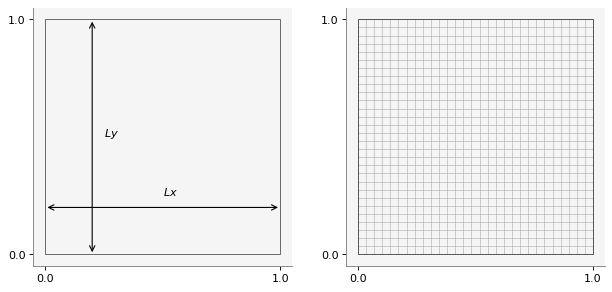

In [15]:
vis = mvis.Plotter(1,2,[dict(aspect='equal'), dict(aspect='equal')], dict(figsize=(8,16)))

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg)
vis.plot_frame(2, xg, yg)

**3. Definir las condiciones iniciales y de frontera:**

Para el caso de la concentración, necesitamos definir la fuente de contaminante en la pared izquierda:

---
<a name='E-2'></a>
### <font color="DodgerBlue">Ejercicio 2.</font>
Calcule el lugar donde se debe aplicar la condición de frontera distinta de cero para la concentración $c$. Recuerde que el intervalo es $y \in [\frac{3}{8} Ly, \frac{5}{8}Ly]$.

---

In [18]:
h = np.zeros((Nx+2, Ny+2))
h[0,:]    = 50  # Pared izquierda    
h[Nx+1,:] = 0   # Pared derecha

c = np.zeros((Nx+2, Ny+2))
c[0,:]    = 0  # Pared izquierda    
c[Nx+1,:] = 0   # Pared derecha
c[:,0]    = 0  # Pared inferior
c[:,Ny+1] = 0   # Pared superior

### BEGIN SOLUTION
N1 = int((Ly * 3.0 / 8.0) / 𝛿)
N2 = int((Ly * 5.0 / 8.0) / 𝛿)

file_answer.write('3', N1, 'Revisa el cálculo de límite inferior del intervalo')
file_answer.write('4', N2, 'Revisa el cálculo de límite superior del intervalo')
### END SOLUTION
c[0, N1:N2]    = 50  # Pared izquierda

print('N1 = {}'.format(N1))
print('N2 = {}'.format(N2))

N1 = 10
N2 = 18


In [19]:
quizz.eval_numeric('3', N1)
quizz.eval_numeric('4', N2)

----------------------------------------
3 | Tu resultado es correcto.
----------------------------------------
----------------------------------------
4 | Tu resultado es correcto.
----------------------------------------


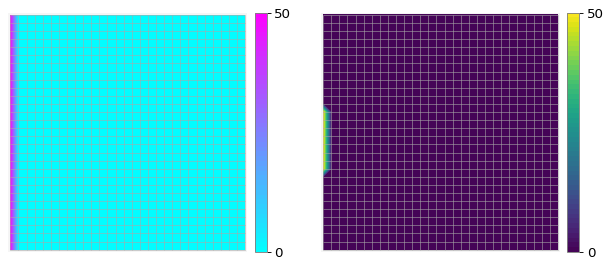

In [20]:
vis = mvis.Plotter(1,2,[dict(aspect='equal'), dict(aspect='equal')], dict(figsize=(8,16)))

cax1 = vis.set_canvas(1,Lx,Ly)
c_h = vis.contourf(1, xg, yg, h, levels=50, cmap='cool')
vis.fig.colorbar(c_h, cax=cax1, ticks = [h.min(), h.max()], shrink=0.5, orientation='vertical')
vis.plot_mesh2D(1, xg, yg)

cax2 = vis.set_canvas(2,Lx,Ly)
c_c = vis.contourf(2, xg, yg, c, levels=50, cmap='viridis')
vis.fig.colorbar(c_c, cax=cax2, ticks = [c.min(), c.max()], shrink=0.5, orientation='vertical')
vis.plot_mesh2D(2, xg, yg)

**4. Implementar el algoritmo de solución:**
$$
\begin{eqnarray}
h_{i,j}^{n+1} & = & h_{i,j}^n + \dfrac{\delta_t K_{i,j}}{\delta^2} 
\left(h_{i+1,j}^n + h_{i-1,j}^n + h_{i,j+1}^n + h_{i,j-1}^n - 4h_{i,j}^n\right) \\
(Vx_{i,j}, Vy_{i,j}) & = & -\dfrac{K_{i,j}}{2 \delta} (h_{i+1,j} - h_{i-1,j}, h_{i,j+1} - h_{i,j-1}) \\
c_{i,j}^{n+1} & = & c_{i,j}^n + \dfrac{\delta_t Dx_{i,j}}{\delta^2} 
\left(c_{i+1,j}^n - 2c_{i,j}^n + c_{i-1,j}^n\right) + \dfrac{\delta_t Dx_{i,j}}{\delta^2}\left(c_{i,j+1}^n - 2c_{i,j}^n + c_{i,j-1}^n  \right) - \\
& & \dfrac{\delta_t Vx_{i,j}}{2\delta} (c_{i+1,j} - c_{i-1,j}) 
  - \dfrac{\delta_t Vy_{i,j}}{2\delta} (c_{i,j+1} - c_{i,j-1})
\end{eqnarray} 
$$


In [21]:
𝛿t = 0.0001
r = 𝛿t / 𝛿**2
s = 1.0 / 2*𝛿
t = 𝛿t / 2*𝛿

h_new = h.copy()
c_new = c.copy()

tolerancia = 1.0e-3 
error = 1.0
error_lista = []

Vx = np.zeros((Nx+2, Ny+2))
Vy = Vx.copy()

**4.1 Hacemos una prueba resolviendo primero la ecuación de flujo**

---
<a name='E-3'></a>
### <font color="DodgerBlue">Ejercicio 3.</font>
Implemente la fórmula en diferencias para la carga hidráulica $h$.

---

In [24]:
iteraciones_max = 1000
iteraciones = 0
while(error > tolerancia and iteraciones < iteraciones_max):
    iteraciones += 1
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if j == 1:  # No flujo en la pared inferior
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] - 3*h[i,j])
            if j == Ny: # No flujo en la pared superior
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j-1] - 3*h[i,j])
            else:
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] + h[i,j-1] - 4*h[i,j])
                
    # Condición de frontera de no flujo
    h_new[:,0] = h_new[:,1]
    h_new[:,Ny+1] = h_new[:,Ny]
    
    # Actualización de la carga hidráulica
    h[:] = h_new[:]
    
#    print(iteraciones, sep=' ', end= ' ')


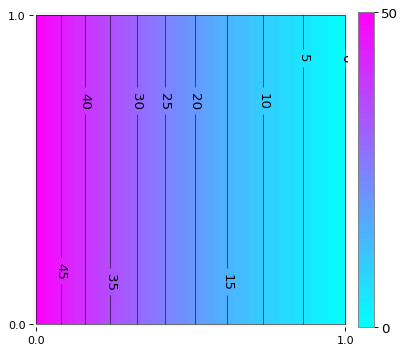

In [25]:
vis = mvis.Plotter(1,1,[dict(aspect='equal')])

cax1 = vis.set_canvas(1,Lx,Ly)
c_h = vis.contourf(1, xg, yg, h, levels=50, cmap='cool')
cl_h = vis.contour(1, xg, yg, h, levels=10, colors='k', linewidths=0.5)
plt.clabel(cl_h, inline=True, fontsize=12.0)
vis.fig.colorbar(c_h, cax=cax1, ticks = [h.min(), h.max()], shrink=0.5, orientation='vertical')
vis.plot_frame(1, xg, yg)

**4.2 Calculamos ahora la velocidad con la $h$ antes calculada**

---
<a name='E-4'></a>
### <font color="DodgerBlue">Ejercicio 4.</font>
Calcule la velocidad con la fórmula correspondiente.

---

In [28]:
### BEGIN SOLUTION
for i in range(1,Nx+1):
    for j in range(1,Ny+1):
        Vx[i,j] = -K * s * (h[i+1,j] - h[i-1,j])
        Vy[i,j] = -K * s * (h[i,j+1] - h[i,j-1])
        
file_answer.write('5', Vx,'')
file_answer.write('6', Vy,'')
### END SOLUTION


In [27]:
quizz.eval_numeric('5', Vx)
quizz.eval_numeric('6', Vy)

----------------------------------------
5 | Tu resultado es correcto.
----------------------------------------
----------------------------------------
6 | Tu resultado es correcto.
----------------------------------------


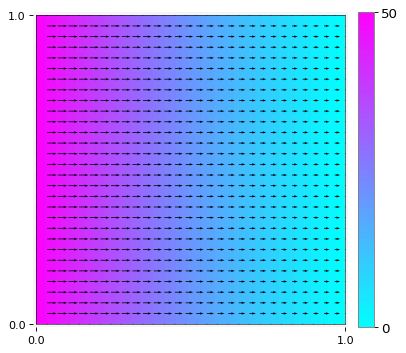

In [29]:
vis = mvis.Plotter(1,1,[dict(aspect='equal')])

cax1 = vis.set_canvas(1,Lx,Ly)
c_h = vis.contourf(1, xg, yg, h, levels=50, cmap='cool')
vis.fig.colorbar(c_h, cax=cax1, ticks = [h.min(), h.max()], shrink=0.5, orientation='vertical')
vis.plot_frame(1, xg, yg)
vis.quiver(1, xg, yg, Vx, Vy, scale=2.5)
vis.show()

**4.3 Implementamos el algoritmo completo**
$$
\begin{eqnarray}
h_{i,j}^{n+1} & = & h_{i,j}^n + \dfrac{\delta_t K_{i,j}}{\delta^2} 
\left(h_{i+1,j}^n + h_{i-1,j}^n + h_{i,j+1}^n + h_{i,j-1}^n - 4h_{i,j}^n\right) \\
(Vx_{i,j}, Vy_{i,j}) & = & -\dfrac{K_{i,j}}{2 \delta} (h_{i+1,j} - h_{i-1,j}, h_{i,j+1} - h_{i,j-1}) \\
c_{i,j}^{n+1} & = & c_{i,j}^n + 
\dfrac{\delta_t Dx_{i,j}}{\delta^2  \phi} \left(c_{i+1,j}^n - 2c_{i,j}^n + c_{i-1,j}^n\right) + \dfrac{\delta_t Dx_{i,j}}{\delta^2  \phi} \left(c_{i,j+1}^n - 2c_{i,j}^n + c_{i,j-1}^n  \right) - \\
& & \dfrac{\delta_t Vx_{i,j}}{2\delta  \phi} (c_{i+1,j} - c_{i-1,j}) 
  - \dfrac{\delta_t Vy_{i,j}}{2\delta  \phi} (c_{i,j+1} - c_{i,j-1})
\end{eqnarray} 
$$

---
<a name='E-5'></a>
### <font color="DodgerBlue">Ejercicio 5.</font>
Complete el cálculo de la concentración $c$ en el código que sigue.

---

In [30]:
h = np.ones((Nx+2, Ny+2)) * 25
h[0,:]    = 50  # Pared izquierda    
h[Nx+1,:] = 0   # Pared derecha

c = np.zeros((Nx+2, Ny+2))
c[0,:]    = 0  # Pared izquierda    
c[Nx+1,:] = 0   # Pared derecha
c[:,0]    = 0  # Pared inferior
c[:,Ny+1] = 0   # Pared superior

c[0, N1:N2]    = 50  # Pared izquierda

iteraciones_max = 1000
iteraciones = 0
while(error > tolerancia and iteraciones < iteraciones_max):
    iteraciones += 1
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if j == 1:  # No flujo 
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] - 3*h[i,j])
            if j == Ny: # No flujo
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j-1] - 3*h[i,j])
            else:
                h_new[i,j] = h[i,j] + K * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] + h[i,j-1] - 4*h[i,j])

    h_new[:,0] = h_new[:,1]
    h_new[:,Ny+1] = h_new[:,Ny]
    
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            Vx[i,j] = -K * s * (h[i+1,j] - h[i-1,j])
            Vy[i,j] = -K * s * (h[i,j+1] - h[i,j-1])

    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if j == 1:  # No flujo 
                c_new[i,j] = c[i,j] + Dx * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙 \
                                    + Dy * r * (c[i,j+1] - c[i,j]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    - t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙
            if j == Ny: # No flujo
                c_new[i,j] = c[i,j] + Dx * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙\
                                    + Dy * r * (c[i,j-1] - c[i,j]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    - t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙
            if i == Nx: # No flujo
                c_new[i,j] = c[i,j] + Dx * r * (c[i-1,j] - c[i,j]) / 𝜙 \
                                    + Dy * r * (c[i,j+1] - 2*c[i,j]+ c[i,j-1]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    + t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙              
            else:
                c_new[i,j] = c[i,j] + Dx * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙\
                                + Dy * r * (c[i,j+1] - 2*c[i,j]+ c[i,j-1]) / 𝜙\
                                - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙\
                                - t * Vy[i,j] * (c[i,j+1] - c[i,j-1])/ 𝜙
                
    c_new[:,0] = c_new[:,1]
    c_new[:,Ny+1] = c_new[:,Ny]
    c_new[Nx+1:] = c_new[Nx,:]
    
    error = np.linalg.norm(h_new - h)
    error_lista.append(error)
    h[:] = h_new[:]
    c[:] = c_new[:]
    
    print(iteraciones, sep=' ', end= ' ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

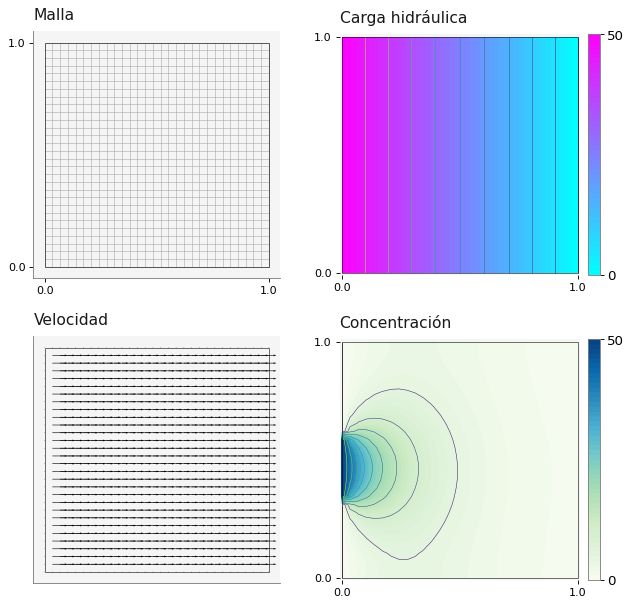

In [18]:
ax1 = dict(aspect='equal', title='Malla')
ax2 = dict(aspect='equal', title='Carga hidráulica')
ax3 = dict(aspect='equal', title='Velocidad')
ax4 = dict(aspect='equal', title='Concentración')

vis = mvis.Plotter(2,2,[ax1, ax2, ax3, ax4],
                  dict(figsize=(8,8)))

vis.plot_mesh2D(1, xg, yg)
vis.plot_frame(1, xg, yg)

cax3 = vis.set_canvas(2,Lx,Ly)
c_h = vis.contourf(2, xg, yg, h, levels=50, cmap='cool')
vis.fig.colorbar(c_h, cax=cax3, ticks = [h.min(), h.max()], shrink=0.5, orientation='vertical')
vis.contour(2, xg, yg, h, levels=10, linewidths=0.5)
vis.plot_frame(2, xg, yg)

vis.plot_frame(3, xg, yg)
vis.quiver(3, xg, yg, Vx, Vy, scale=1)

cax4 = vis.set_canvas(4,Lx,Ly)
c_c = vis.contourf(4, xg, yg, c, levels=50, cmap='GnBu')
vis.fig.colorbar(c_c, cax=cax4, ticks = [c.min(), c.max()], shrink=0.5, orientation='vertical')
vis.contour(4, xg, yg, c, levels=10, linewidths=0.5)
vis.plot_frame(4, xg, yg)

vis.show()

**¿Podría hacer el mismo cálculo con una permeabilidad hidráulica y dipersividad variable en el dominio de estudio?**

In [31]:
K = np.ones((Nx+2, Ny+2))

nn1 = int(Ny*0.25)
nn2 = int(Ny*.75)
print(nn1, nn2, nn2-nn1)
K[:, nn1:nn2] = np.random.rand(Nx+2, nn2-nn1) * 0.5

Dx = np.random.rand(Nx+2, Ny+2) * 0.5
Dy = np.random.rand(Nx+2, Ny+2) * 2.5

7 21 14


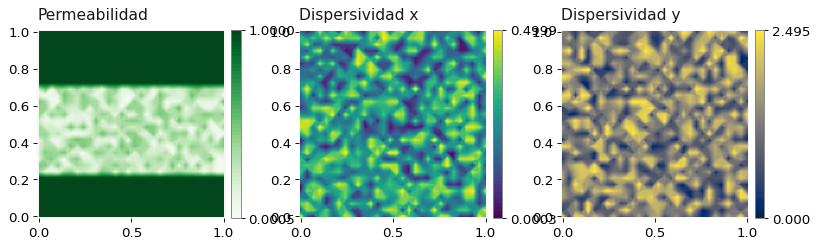

In [32]:
ax1 = dict(aspect='equal', title='Permeabilidad')
ax2 = dict(aspect='equal', title='Dispersividad x')
ax3 = dict(aspect='equal', title='Dispersividad y')

vis = mvis.Plotter(1,3,[ax1, ax2, ax3],
                  dict(figsize=(10,8)))

cax1 = vis.set_canvas(1,Lx,Ly)
p_v = vis.contourf(1, xg, yg, K, levels=50, cmap='Greens')
vis.fig.colorbar(p_v, cax=cax1, ticks = [K.min(), K.max()], shrink=0.5, orientation='vertical')

cax2 = vis.set_canvas(2,Lx,Ly)
d_x = vis.contourf(2, xg, yg, Dx, levels=50, cmap='viridis')
vis.fig.colorbar(d_x, cax=cax2, ticks = [Dx.min(), Dx.max()], shrink=0.5, orientation='vertical')

cax3 = vis.set_canvas(3,Lx,Ly)
d_y = vis.contourf(3, xg, yg, Dy, levels=50, cmap='cividis')
vis.fig.colorbar(d_y, cax=cax3, ticks = [Dy.min(), Dy.max()], shrink=0.5, orientation='vertical')

vis.show()

---
<a name='E-6'></a>

### <font color="DodgerBlue">Ejercicio 6.</font>
Copie y modifique el código que calcula toda la solución, de tal manera que tome en cuenta la permeabilidad hidráulica y la dispersividad variables.

---

In [33]:
### BEGIN SOLUTION
h = np.ones((Nx+2, Ny+2)) * 25
h[0,:]    = 50  # Pared izquierda    
h[Nx+1,:] = 0   # Pared derecha

c = np.zeros((Nx+2, Ny+2))
c[0,:]    = 0  # Pared izquierda    
c[Nx+1,:] = 0   # Pared derecha
c[:,0]    = 0  # Pared inferior
c[:,Ny+1] = 0   # Pared superior

c[0, N1:N2]    = 50  # Pared izquierda

iteraciones_max = 1000
iteraciones = 0
while(error > tolerancia and iteraciones < iteraciones_max):
    iteraciones += 1
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if j == 1:  # No flujo 
                h_new[i,j] = h[i,j] + K[i,j] * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] - 3*h[i,j])
            if j == Ny: # No flujo
                h_new[i,j] = h[i,j] + K[i,j] * r * (h[i+1,j] + h[i-1,j] + h[i,j-1] - 3*h[i,j])
            else:
                h_new[i,j] = h[i,j] + K[i,j] * r * (h[i+1,j] + h[i-1,j] + h[i,j+1] + h[i,j-1] - 4*h[i,j])

    h_new[:,0] = h_new[:,1]
    h_new[:,Ny+1] = h_new[:,Ny]
    
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            Vx[i,j] = -K[i,j] * s * (h[i+1,j] - h[i-1,j])
            Vy[i,j] = -K[i,j] * s * (h[i,j+1] - h[i,j-1])

    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            if j == 1:  # No flujo 
                c_new[i,j] = c[i,j] + Dx[i,j] * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙 \
                                    + Dy[i,j] * r * (c[i,j+1] - c[i,j]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    - t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙
            if j == Ny: # No flujo
                c_new[i,j] = c[i,j] + Dx[i,j] * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙\
                                    + Dy[i,j] * r * (c[i,j-1] - c[i,j]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    - t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙
            if i == Nx: # No flujo
                c_new[i,j] = c[i,j] + Dx[i,j] * r * (c[i-1,j] - c[i,j]) / 𝜙 \
                                    + Dy[i,j] * r * (c[i,j+1] - 2*c[i,j]+ c[i,j-1]) / 𝜙 \
                                    - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙 \
                                    + t * Vy[i,j] * (c[i,j+1] - c[i,j-1]) / 𝜙              
            else:
                c_new[i,j] = c[i,j] + Dx[i,j] * r * (c[i+1,j] - 2*c[i,j]+ c[i-1,j]) / 𝜙\
                                + Dy[i,j] * r * (c[i,j+1] - 2*c[i,j]+ c[i,j-1]) / 𝜙\
                                - t * Vx[i,j] * (c[i+1,j] - c[i-1,j]) / 𝜙\
                                - t * Vy[i,j] * (c[i,j+1] - c[i,j-1])/ 𝜙
    
    c_new[:,0] = c_new[:,1]
    c_new[:,Ny+1] = c_new[:,Ny]
    c_new[Nx+1:] = c_new[Nx,:]
    
    error = np.linalg.norm(h_new - h)
    error_lista.append(error)
    h[:] = h_new[:]
    c[:] = c_new[:]
    
#    print(iteraciones, sep=' ', end= ' ')
### END SOLUTION

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

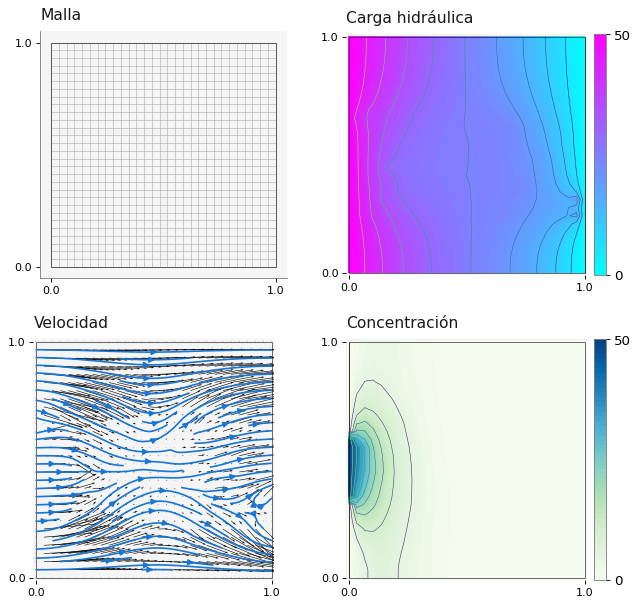

In [34]:
ax1 = dict(aspect='equal', title='Malla')
ax2 = dict(aspect='equal', title='Carga hidráulica')
ax3 = dict(aspect='equal', title='Velocidad')
ax4 = dict(aspect='equal', title='Concentración')

vis = mvis.Plotter(2,2,[ax1, ax2, ax3, ax4],
                  dict(figsize=(8,8)))

vis.plot_mesh2D(1, xg, yg)
vis.plot_frame(1, xg, yg)

cax3 = vis.set_canvas(2,Lx,Ly)
c_h = vis.contourf(2, xg, yg, h, levels=50, cmap='cool')
vis.fig.colorbar(c_h, cax=cax3, ticks = [h.min(), h.max()], shrink=0.5, orientation='vertical')
vis.contour(2, xg, yg, h, levels=10, linewidths=0.5)
vis.plot_frame(2, xg, yg)

vis.set_canvas(3,Lx,Ly)
vis.plot_frame(3, xg, yg)
vis.streamplot(3, xg, yg, Vx, Vy)
vis.quiver(3, xg, yg, Vx, Vy, scale=0.5)

cax4 = vis.set_canvas(4,Lx,Ly)
c_c = vis.contourf(4, xg, yg, c, levels=50, cmap='GnBu')
vis.fig.colorbar(c_c, cax=cax4, ticks = [c.min(), c.max()], shrink=0.5, orientation='vertical')
vis.contour(4, xg, yg, c, levels=10, linewidths=0.5)
vis.plot_frame(4, xg, yg)

plt.savefig('contaminante.pdf')
vis.show()
